In [1]:
# Comparing RO to INS data

import sys
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts")
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts/config")
sys.path.append("/Users/roberto/code/corelibs/src/tools-python")
sys.path.append("/Users/roberto/code/corelibs/build/datatypes")
sys.path.append("/Users/roberto/code/corelibs/build/datatypes/datatypes_python")
sys.path.append("/Users/roberto/code/radar-utilities/build/radarutilities_datatypes_python")
from figs import plot
import motion

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
from numpy import *
import module
import settings

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# text
plt.rc("text", usetex=True)
plt.rc("font", family=settings.FONT_FAMILY)

module.set_sys_paths()

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

from mrg.logging.monolithic_encoder import encodeForMonolithic
sys.path.append("/Users/roberto/code/radar-utilities/build/radarutilities_datatypes_python/"
                "protobuf/classification_score")
import pbClassificationScore_pb2 as pbClassificationScore_pb2

import numpy as np
from config.data import *

In [2]:
# INS_relative_poses_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-16-24-39-long-hanborough-to-ori-V4-radar-leopon-trial-sunny-long-range/motion_estimation/ground-truth/flattened_novatel_generated_poses.monolithic"
# RO_relative_poses_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-16-24-39-long-hanborough-to-ori-V4-radar-leopon-trial-sunny-long-range/motion_estimation/standard-ro/radar_motion_estimation.monolithic"

INS_relative_poses_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/ground-truth/flattened_novatel_generated_poses.monolithic"
RO_relative_poses_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/standard-ro/radar_motion_estimation.monolithic"

# INS_relative_poses_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/2018-07-27-15-35-23-long-hanbourgh-to-ori/motion_estimation/ground-truth/flattened_novatel_generated_poses.monolithic"
# RO_relative_poses_path = "/Users/roberto/data/odometry-comparisons/rugged_ro/2018-07-27-15-35-23-long-hanbourgh-to-ori/motion_estimation/standard-ro/radar_motion_estimation.monolithic"

# INS - open monolithic and iterate frames
print("reading INS_relative_poses_path: " + INS_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    INS_relative_poses_path)

# iterate mono
INS_se3s = []
INS_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    INS_se3s.append(serialised_transform[0])
    INS_timestamps.append(serialised_transform[1])
    
# RO - open monolithic and iterate frames
print("reading RO_relative_poses_path: " + RO_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    RO_relative_poses_path)

# iterate mono
RO_se3s = []
RO_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    RO_se3s.append(serialised_transform[0])
    RO_timestamps.append(serialised_transform[1])

reading INS_relative_poses_path: /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/ground-truth/flattened_novatel_generated_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
reading RO_relative_poses_path: /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/standard-ro/radar_motion_estimation.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2


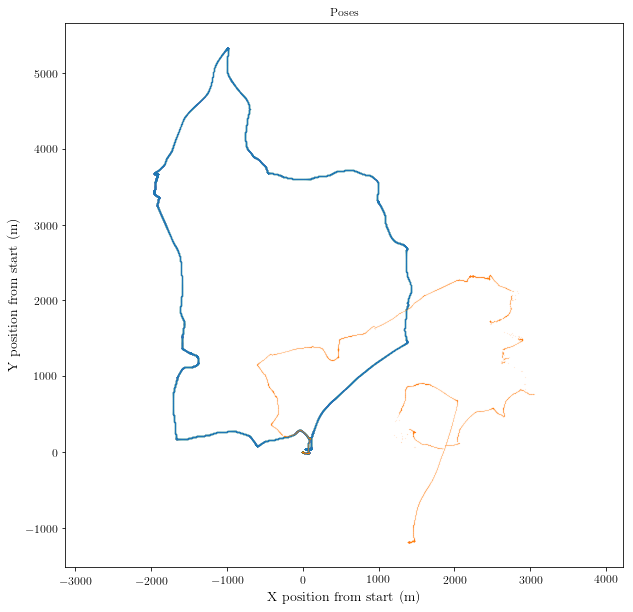

In [3]:
# get INS poses
INS_poses = []
pose = np.identity(4)
for i in range(len(INS_se3s)):
    pose = pose * INS_se3s[i]
    INS_poses.append(pose)

# get x,y coords
x_INS = [pose[0, 3] for pose in INS_poses]
y_INS = [pose[1, 3] for pose in INS_poses]

# get RO poses
RO_poses = []
pose = np.identity(4)
for i in range(len(RO_se3s)):
    pose = pose * RO_se3s[i]
    RO_poses.append(pose)

# get x,y coords
x_RO = [pose[0, 3] for pose in RO_poses]
y_RO = [pose[1, 3] for pose in RO_poses]

plt.figure(figsize=(10,10))
plt.plot(x_INS,y_INS,'.',markersize=0.1);
plt.plot(x_RO,y_RO,'.',markersize=0.1);
plt.axis('equal');
plt.title('Poses');
plt.xlabel('X position from start (m)');
plt.ylabel('Y position from start (m)');

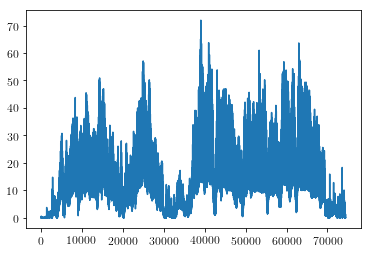

In [4]:
# get INS speeds
assert len(INS_se3s) == len(INS_timestamps)
INS_speeds = []
INS_TIMESTAMPS = []
deltatime_arr = []
for i in range(len(INS_timestamps) - 1):
# for i in range(0,len(timestamps) - 1,10): # this fixed the glitches by skipping them
# for i in range(1000,2000):
    # work out speed
    delta_time = INS_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION \
        - INS_timestamps[i] / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = INS_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    INS_speeds.append(speed)
    INS_TIMESTAMPS.append(INS_timestamps[i])
# plt.ylim(0,1000000)
plt.plot(INS_speeds);

In [5]:
# get speeds
assert len(RO_se3s) == len(RO_timestamps)
RO_speeds = []
RO_TIMESTAMPS = []
deltatime_arr = []
for i in range(len(RO_timestamps) - 1):
# for i in range(0,len(timestamps) - 1,10): # this fixed the glitches by skipping them
# for i in range(1000,2000):
    # work out speed
    delta_time = RO_timestamps[i + 1] / settings.TIMESTAMP_CONVERSION \
        - RO_timestamps[i] / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = RO_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    RO_speeds.append(speed)
    RO_TIMESTAMPS.append(RO_timestamps[i])
# plt.plot(RO_speeds);

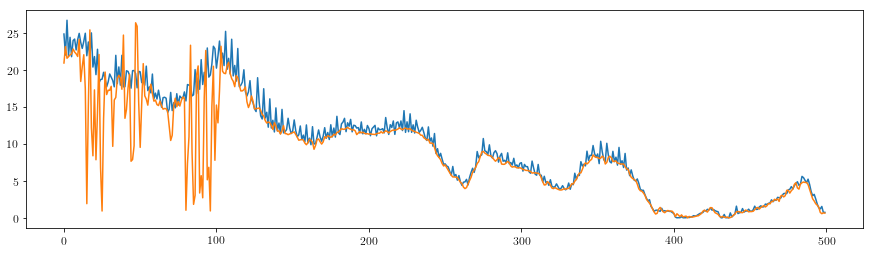

In [6]:
# Do interpolation (accumulatation for now)
interp_INS_speed = []
distance = 0
temp_speed = 0
j = 0
for i in range(len(RO_timestamps)):
    while(INS_timestamps[j] < RO_timestamps[i]):
        distance += INS_speeds[j]*(INS_timestamps[j]-INS_timestamps[j-1])
        j+=1
    temp_speed = distance/(RO_timestamps[i]-RO_timestamps[i-1])
    interp_INS_speed.append(temp_speed)
    distance = 0
plt.figure(figsize=(15,4))
plt.plot(interp_INS_speed[2000:2500])
plt.plot(RO_speeds[2000:2500])

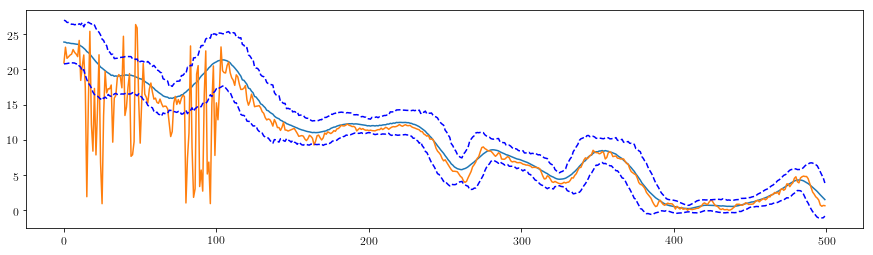

In [7]:
window_size = 20
std_devs = []
means = []
n_sigmas = 2
for i in range(window_size//2,len(interp_INS_speed)-window_size//2):
    window_contents = interp_INS_speed[i-window_size//2:i+window_size//2]
    std_devs.append(std(window_contents))
    means.append(mean(window_contents))
    
means = np.array(means)
means[-window_size//2:] = 0
means = np.roll(means,window_size//2)

std_devs = np.array(std_devs)
std_devs[-window_size//2:] = 0
std_devs = np.roll(std_devs,window_size//2)

plt.figure(figsize=(15,4))
plt.plot(means[2000:2500])
plt.plot(RO_speeds[2000:2500])
plt.plot(means[2000:2500]+n_sigmas*std_devs[2000:2500],'b--')
plt.plot(means[2000:2500]-n_sigmas*std_devs[2000:2500],'b--')
# plt.plot(means[2000:2500])
# plt.plot(RO_speeds[2005:2505])
# plt.plot(means[2000:2500]+n_sigmas*std_devs[2000:2500],'b--')
# plt.plot(means[2000:2500]-n_sigmas*std_devs[2000:2500],'b--')

(-5, 100)

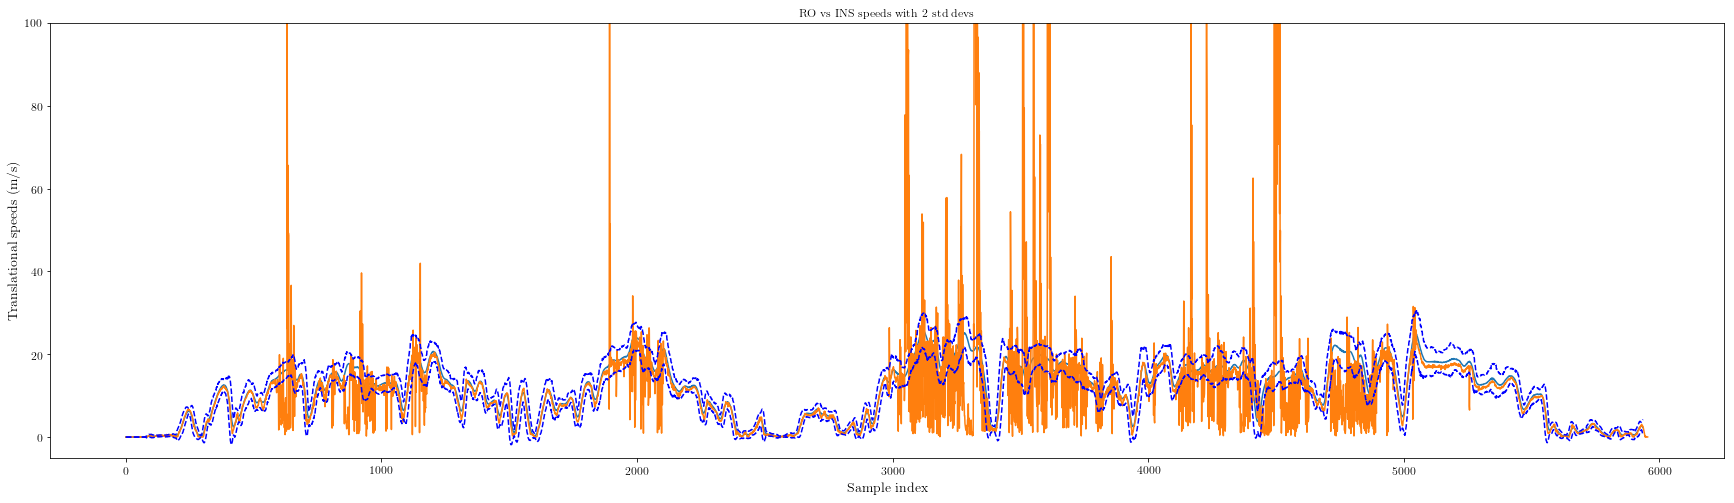

In [8]:
plt.figure(figsize=(30,8))
plt.title('RO vs INS speeds with 2 std devs')
plt.ylabel('Translational speeds (m/s)')
plt.xlabel('Sample index')
plt.plot(means)
plt.plot(RO_speeds)
plt.plot(means+n_sigmas*std_devs,'b--')
plt.plot(means-n_sigmas*std_devs,'b--')
# plt.plot(means+3*std_devs,'k--')
# plt.plot(means-3*std_devs,'k--')
plt.ylim(-5,100)

In [9]:
# Checking for failures based on speeds (not accelerations)
m = len(means)
upper_thresh = means + n_sigmas*std_devs
lower_thresh = means - n_sigmas*std_devs
minimum_speed_to_label = 0.5
label_reach_back = 0
classification = ones(m)*-1
for i in range(m):
    if(RO_speeds[i] < lower_thresh[i]) or RO_speeds[i] > upper_thresh[i]:
        if(means[i] > minimum_speed_to_label):
            classification[i-label_reach_back:i+1] = 1;
#     else:
#         classification[i+window_size//2,] = -1;

Detected failures: 1265 of 5936 samples


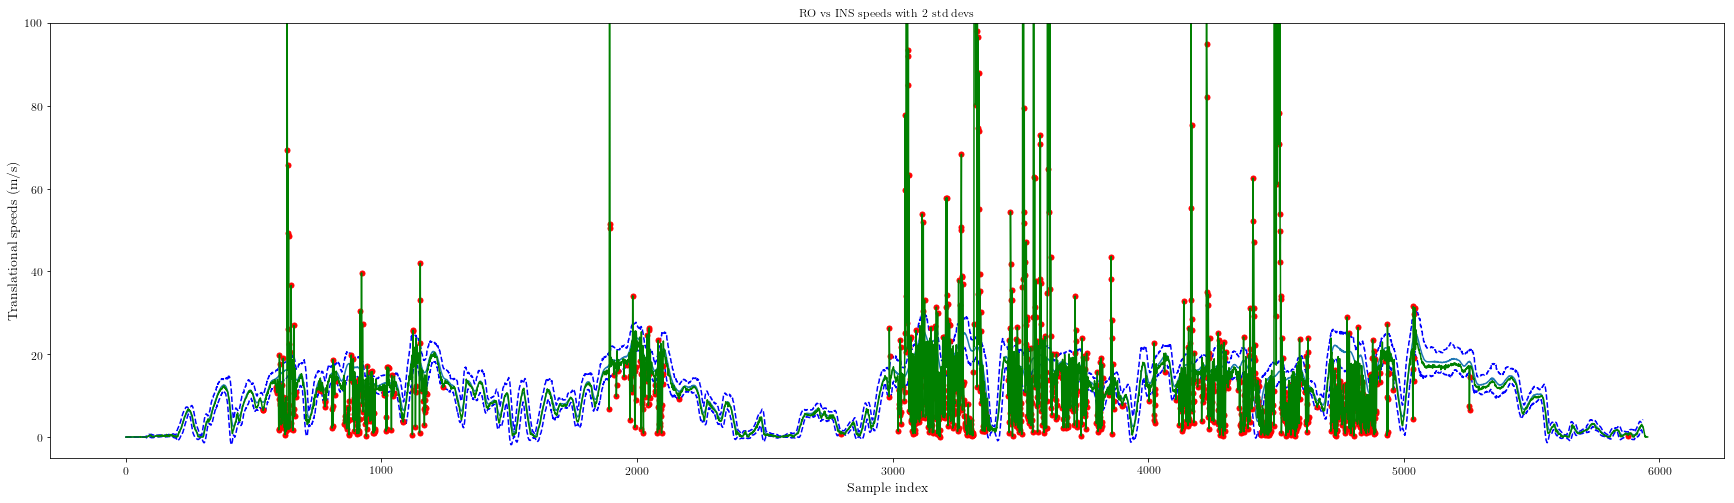

In [10]:
plt.figure(figsize=(30,8))
plt.title('RO vs INS speeds with 2 std devs')
plt.ylabel('Translational speeds (m/s)')
plt.xlabel('Sample index')
plt.plot(means)
plt.plot(means+n_sigmas*std_devs,'b--')
plt.plot(means-n_sigmas*std_devs,'b--')
for i in range(m):
    if(classification[i] == 1):
        plt.plot(i,RO_speeds[i],'r.-',markersize=10)
#     else:
plt.plot(RO_speeds,'g-',markersize=0.5) 
plt.ylim(-5,100)

tally = 0;
for i in range(m):
    if(classification[i] == 1):
        tally+=1
print('Detected failures:',tally,"of",m,'samples')

In [11]:
plot_poses = False
if(plot_poses == True):
    plt.figure(figsize=(10,10))
    for i in range(m):
        if(classification[i] == 1):
            plt.plot(x_RO[i],y_RO[i],'r.',markersize=2);
        else:
            plt.plot(x_RO[i],y_RO[i],'b.',markersize=0.5);

    plt.axis('equal');
    plt.title('Poses where RO has failure (red) and been within the INS threshold (blue)');
    plt.xlabel('X position from start (m)');
    plt.ylabel('Y position from start (m)');

In [12]:
# from sklearn import datasets

plot_figures = True
dateAndTime = "2019-03-18-15-00-42/";
filename = "/Users/roberto/data/odometry-comparisons/rugged_ro/"\
"2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/standard-ro/"+dateAndTime;
print('Reading from: ' + filename)
failure_label = 1

# Read from files into dataframes
# df_xyz_yaw = pd.read_csv(filename+'xyz_yaw.csv',names=range(4))
df_MaxEVec = pd.read_csv(filename+'MaxEVec.csv',names=range(2400))

# print("Shape of xyz_yaw is:\n",shape(df_xyz_yaw))
print("Shape of MaxEVec is:\n",shape(df_MaxEVec))
[a,b] = shape(df_MaxEVec)


Reading from: /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/standard-ro/2019-03-18-15-00-42/
Shape of MaxEVec is:
 (5955, 2400)


In [13]:
where_are_NaNs = isnan(df_MaxEVec)
df_MaxEVec[where_are_NaNs] = 0.0
df_MaxEVec.head()
EVec_timestamps = df_MaxEVec[[0]]
EVec_timestamps = np.array(EVec_timestamps)
max_evec = np.copy(df_MaxEVec.iloc[:,1:2400].values)

In [14]:
# Get error indices
labels = [] #zeros(len(EVec_timestamps))
for i in range(m):
    if(classification[i] == 1):
        labels.append(1)
    else:
        labels.append(-1)
print(size(labels))

5936


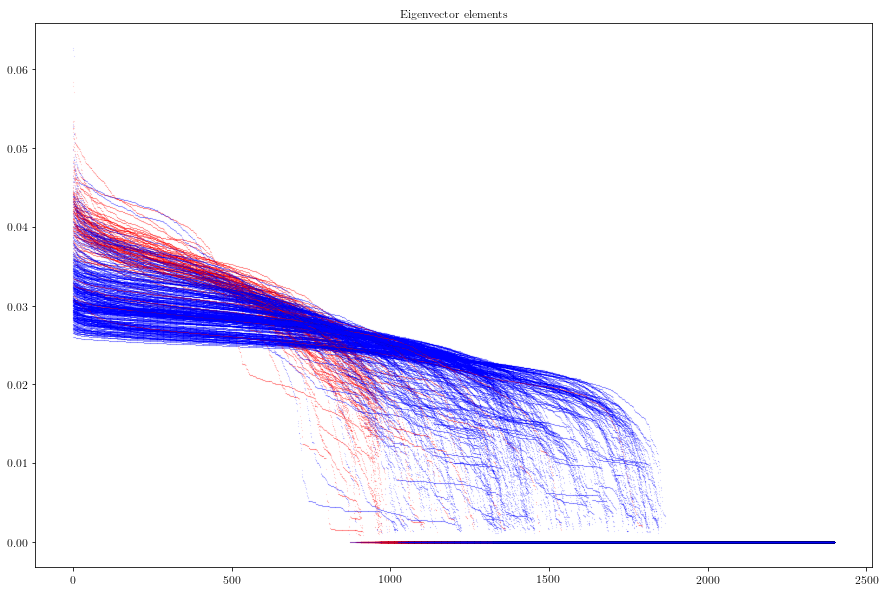

In [15]:
plt.figure(figsize=(15,10))
plt.title('Eigenvector elements');
sorted_max_evecs = max_evec
# for i in range(m): # to print all of them
for i in range(500,800):
    sorted_max_evecs[i] = sort(max_evec[i])[::-1]
    if(labels[i] == failure_label):
        plt.plot(sorted_max_evecs[i,:],'.',markersize=0.1,color='red');
    else:
        plt.plot(sorted_max_evecs[i,:],'.',markersize=0.1,color='blue');

In [16]:
print(size(labels))
print(len(sorted_max_evecs))

5936
5955


In [17]:
start = 0
finish = 2000
combined_data = c_[labels[start:finish], sorted_max_evecs[start:finish]]
# combined_data = c_[labels, sorted_max_evecs[0:m]]
print(combined_data)
print("Saving to directory: ",filename)
savetxt(filename+'tmp_combined_data.csv',combined_data,fmt='%s',delimiter=',');
print(shape(combined_data))

[[-1.         0.0265311  0.0265455 ...  0.         0.         0.       ]
 [-1.         0.0263999  0.0258356 ...  0.         0.         0.       ]
 [-1.         0.0263495  0.0267313 ...  0.         0.         0.       ]
 ...
 [-1.         0.0323723  0.0322549 ...  0.         0.         0.       ]
 [-1.         0.0143759  0.0143519 ...  0.         0.         0.       ]
 [-1.         0.0196002  0.0154263 ...  0.         0.         0.       ]]
Saving to directory:  /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/standard-ro/2019-03-18-15-00-42/
(2000, 2400)


In [18]:
# Write labels to monolithic
labels_filename = "/Users/roberto/data/odometry-comparisons/rugged_ro/"\
"2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/"\
"ground-truth/labels.monolithic"
print("writing to labels monolithic: " + labels_filename + "...")
with open(labels_filename, 'wb') as file_handle:
    for i in range(start,finish):
        pb_classification_score = pbClassificationScore_pb2.pbClassificationScore()
        pb_classification_score.timestamp = RO_timestamps[i]
        pb_classification_score.score = labels[i]
        file_handle.write(
            encodeForMonolithic(
                pb_classification_score,
                'radarutilities.datatypes.protobuf.classification_score.pbClassificationScore') +
            b"\n")
print("Finished.")

writing to labels monolithic: /Users/roberto/data/odometry-comparisons/rugged_ro/2018-06-21-15-58-58-rural-loop-v4-radar-leopon-trial-sunny-long-range/motion_estimation/ground-truth/labels.monolithic...
Finished.


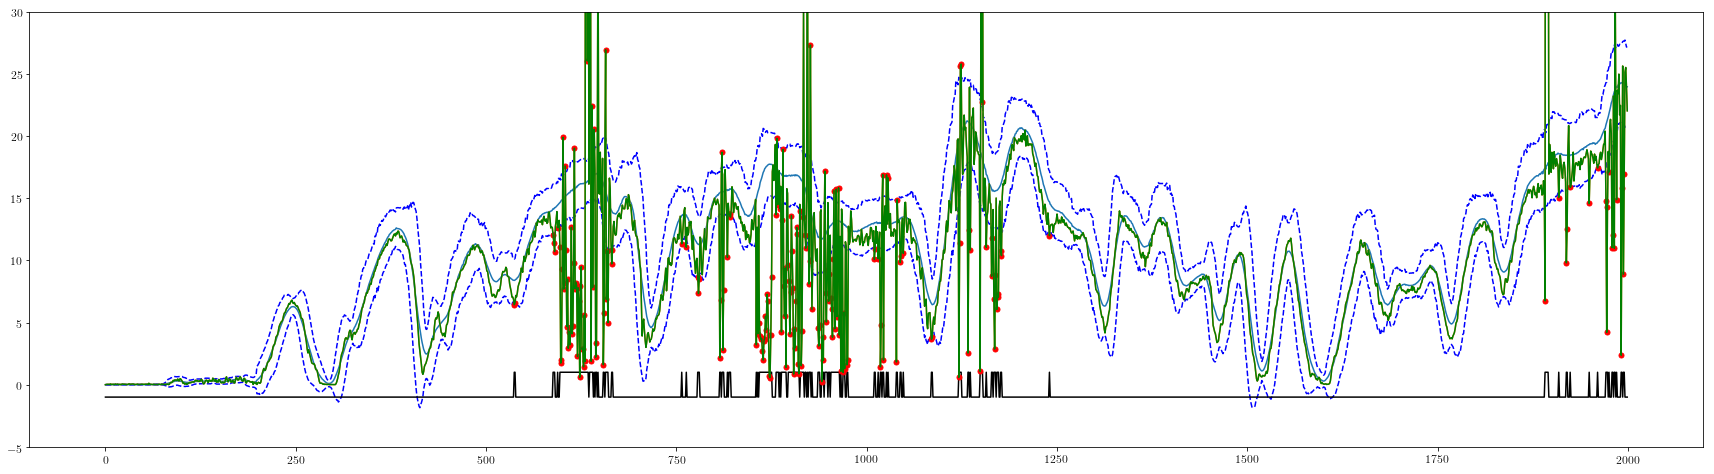

In [19]:
plt.figure(figsize=(30,8))
plt.plot(means[start:finish])
plt.plot(means[start:finish]+n_sigmas*std_devs[start:finish],'b--')
plt.plot(means[start:finish]-n_sigmas*std_devs[start:finish],'b--')
plt.plot(RO_speeds[start:finish]);
plt.plot(labels[start:finish],'k');
for i in range(start,finish):
    if(labels[i] == 1):
        plt.plot(i-start,RO_speeds[i],'r.-',markersize=10)
#     else:
plt.plot(RO_speeds[start:finish],'g-',markersize=0.5)
plt.ylim(-5,30);

In [20]:
print('Instances of RO failure detection')

tally = 0;
for i in range(start,finish):
    if(labels[i] == 1):
        tally+=1
print('Detected failures:',tally,"of",finish-start,'samples')
        

Instances of RO failure detection
Detected failures: 226 of 2000 samples


In [21]:
shape(labels)

(5936,)